# Rate of frequency change of the spectral line

## Questions
1. How does the frequency of maximum of spectral line change over time?
1. Is the rate constant for the whole period when the line is visible?
1. Are the changes of rate periodic?

## Answers
1. It's changing over time, starting from 2010.01 ending in 2014.07
2. The rate is changing over time. 
3. Three first periods when the spectral line is visible and is changing have the same rate of change, the last and the longest one have slower rate of change.


First prepare for calculations

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from datetime import datetime
from obspy import UTCDateTime


import pickle
import glob

from collections import namedtuple

In [2]:
spectra_sz_filepath = 'data/longtermspectra/SZ.LAMP..EHZ_PSD_LONG_PROP_2009-01-01T00:00:00.000000Z_2016-01-01T00:00:00.000000Z_.pickle'

In [3]:
delta_threshold = 0.005
seedid = spectra_sz_filepath.split('/')[-1].split('_')[0]
starttime = datetime(2009,1,1)
endtime = datetime(2016,1,1)

Periodo = namedtuple('Periodo', ['start', 'end', 'color'])

Load the data

In [4]:
with open(spectra_sz_filepath, 'r') as f:
    df = pickle.load(f)

Plot the spectrogram and the maximum of 4.8-4.9Hz part of rolling average with 1 month long period. Afterward clean the data

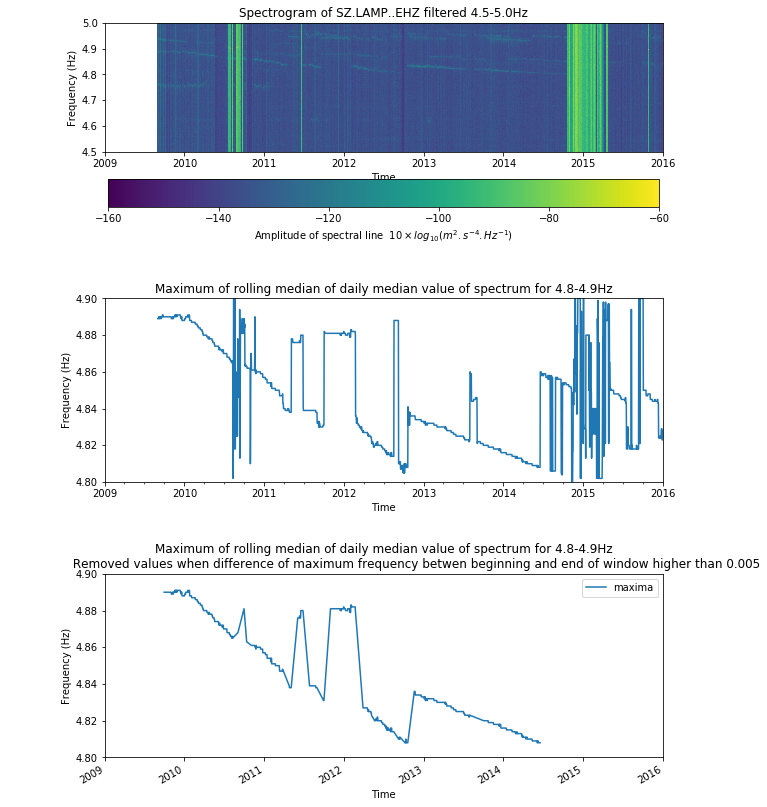

In [5]:
fig, (ax, ax1, ax2) = plt.subplots(nrows=3, figsize=(10, 15))
fig.subplots_adjust(hspace=0.5)

# Daily medians for spectrogram
resamp = df.loc[datetime(2009,9,1):, :].resample('D')
medians = resamp.median()

#Plotting of spectrogram
im = ax.pcolormesh(medians.index.values, medians.columns.values, medians.values.transpose(), vmin=-160, vmax=-60)

# Plotting of maximum of median for rolling average 30 days long
rolling_30d = medians.rolling('30D').median()
rolling_30d['maxima'] = rolling_30d.loc[:, 4.8:4.9].idxmax(axis=1)
rolling_30d['maxima'].plot(ax=ax1)

# Remove points that absolute difference of maximum on the beginning and the end of rolling average is higher than ``delta_threshold`` (0.005)
rolling_30d['delta'] = rolling_30d.loc[:datetime(2014,7,1),'maxima'].rolling(window=30).apply(lambda x: x[0]-x[-1])
rolling_30d_limited_maxima = pd.DataFrame(rolling_30d[abs(rolling_30d.loc[:, 'delta']) < delta_threshold].loc[:, 'maxima'])
rolling_30d_limited_maxima.plot(ax=ax2)

#Labels and limits
cb = fig.colorbar(im, ax=ax, orientation='horizontal')
cb.ax.xaxis.set_label_text(u'Amplitude of spectral line  $10 \\times log_{10} ( m^2 . s^{-4} . Hz^{-1} ) $')

ax.set_title(' '.join(['Spectrogram of', seedid, 'filtered 4.5-5.0Hz']))
ax1.set_title('Maximum of rolling median of daily median value of spectrum for 4.8-4.9Hz')
ax2.set_title('''Maximum of rolling median of daily median value of spectrum for 4.8-4.9Hz
                 Removed values when difference of maximum frequency betwen beginning and end of window higher than {}'''.format(delta_threshold))

ax.set_ylabel('Frequency (Hz)')
ax1.set_ylabel('Frequency (Hz)')
ax2.set_ylabel('Frequency (Hz)')

ax.set_xlabel('Time')
ax1.set_xlabel('Time')
ax2.set_xlabel('Time')

ax.set_xlim((starttime, endtime))
ax1.set_xlim((starttime, endtime))
ax2.set_xlim((starttime, endtime))

ylim = (4.8, 4.9)
ax1.set_ylim(ylim)
ax2.set_ylim(ylim)

fig

Since we know how the maximum changes and how does the rate of change look like, let's divide it into periods of stable change rate.

In [6]:
# Select periods of stable change
periods = [
    Periodo(datetime(2009,10,1), datetime(2010,1,31), 'C1'),
    Periodo(datetime(2010,2,1), datetime(2010,8,1), 'C2'),
    Periodo(datetime(2010,11,1), datetime(2011,5,1), 'C3'),
    Periodo(datetime(2012,4,1), datetime(2012,10,1), 'C4'),
    Periodo(datetime(2012,12,1), datetime(2014,6,15), 'C5'),
]

# Plot lines limiting those periods
for per in periods:
    ax2.plot((per.start, per.start), ylim, c=per.color)
    ax2.plot((per.end, per.end), ylim, c=per.color)


fig

Now let's try fitting a linear function to those separated periods

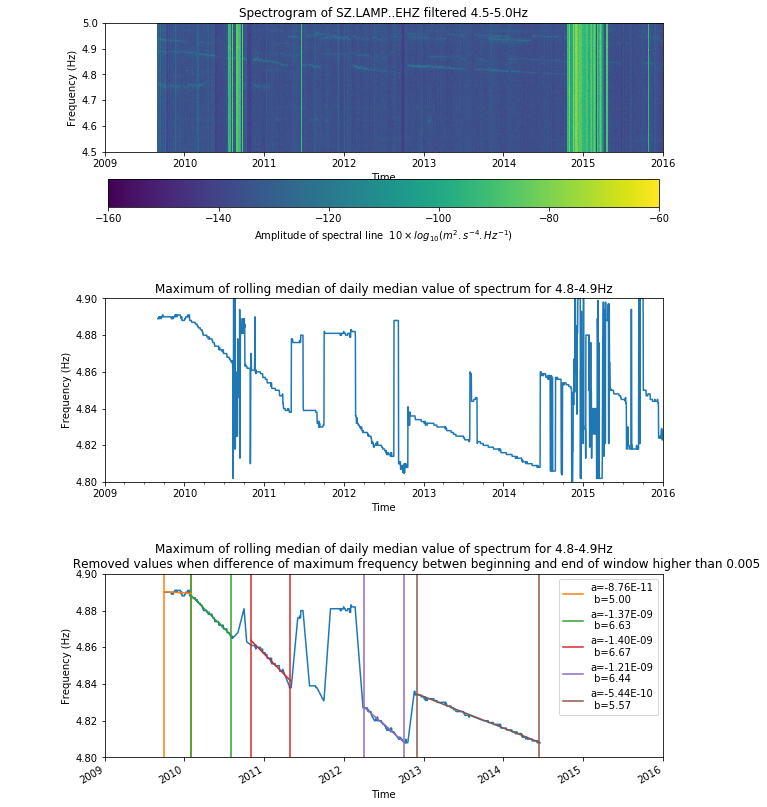

In [7]:
rolling_30d_limited_maxima['timestamp'] = [x.timestamp() for x in rolling_30d_limited_maxima.index]
rolling_30d_limited_maxima

linear = lambda t,a,b: a*t+b
handlers = []
labels = []

for per in periods:    
    popt, pcov = curve_fit(linear,  rolling_30d_limited_maxima.loc[per.start:per.end,'timestamp'], rolling_30d_limited_maxima.loc[per.start:per.end, 'maxima'],  p0=(4, 0.001))
    
    valstart = linear(UTCDateTime(per.start).timestamp, *popt)
    valend = linear(UTCDateTime(per.end).timestamp, *popt)
    
    han, = ax2.plot((per.start,per.end), (valstart, valend), c=per.color )
    handlers.append(han)
    labels.append('a={:.2E}\n b={:.2f}'.format(*popt))
    
leg = ax2.legend(handles=handlers, labels=labels)
    
fig

### Printing figure for report

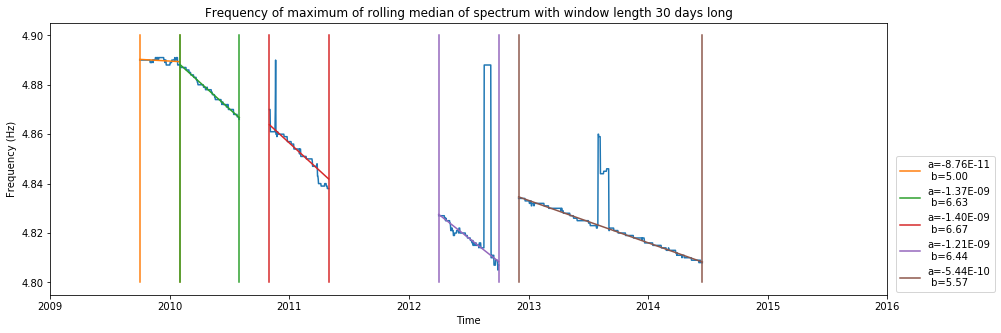

In [8]:
fig, ax = plt.subplots(figsize=(15,5))
df = rolling_30d.copy()
for i, per in enumerate(periods):
    if i == 0:
        df = rolling_30d[per.start:per.end]
    else:
        df = pd.concat([df, rolling_30d[per.start:per.end]])

handlers = []
labels = []

for per in periods:
    ax.plot(df[per.start:per.end].index, df[per.start:per.end]['maxima'], c='C0')
    ax.plot((per.start, per.start), ylim, c=per.color)
    ax.plot((per.end, per.end), ylim, c=per.color)

    popt, pcov = curve_fit(linear,  rolling_30d_limited_maxima.loc[per.start:per.end,'timestamp'], rolling_30d_limited_maxima.loc[per.start:per.end, 'maxima'],  p0=(4, 0.001))
    
    valstart = linear(UTCDateTime(per.start).timestamp, *popt)
    valend = linear(UTCDateTime(per.end).timestamp, *popt)
    
    han, = ax.plot((per.start,per.end), (valstart, valend), c=per.color )
    handlers.append(han)
    labels.append('a={:.2E}\n b={:.2f}'.format(*popt))
    
leg = ax.legend(handles=handlers, labels=labels, loc='lower left', bbox_to_anchor= (1.01, 0.01), ncol=1, 
            borderaxespad=0, frameon=True)
    
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time')
ax.set_xlim((starttime, endtime))

ax.set_title('''Frequency of maximum of rolling median of spectrum with window length 30 days long''')
                 #For purpose of maxima search frequencies were limited to 4.8-4.9Hz''')
                 #Removed values when difference of maximum frequency betwen beginning and end of window higher than {}'''.format(delta_threshold))

fig.savefig('reports/summary/figures/tracking_change.png')

## Observations

- Spectral line at SZ.LAMP have 5 periods where the rate of change is stable
- First one is visible from the beginning of existence of station (2009.08) up to beginning of 2010. *The frequency remain stable*
- Next three periods are lasting for about **half of a year each**. They are separated by periods where spectral line is not visible. Those breaks are not equal in length. The *frequency during those three periods is decreasing with very similar rate* in each of those periods
- Last period starts with higher frequency than the previous period ended. The break inbetween them is short, about two months long. The *rate of frequency decrese is lower than in periods before*.